In [110]:
from screenTools import *
from pathlib import Path

In [111]:
def importPlates(
    xls_path: Str,
    plate_list: list,
    peptide_list: list,
    plate_format: int = 384,
    positive_controls: list = ["A1", "B1", "C1"],
    negative_controls: list = ["D1", "E1", "F1"],
):
    """
    If 384, import plate from single excel sheet, if 96, import an excel file with individual plates as sheets.
    """
    print("importing: ", xls_path)
    if plate_format == 384:
        # upper_left_location = (50, 2) # these should be right if the plate reader saved correctly
        upper_left_location = (52, 2) # these should be right if the plate reader saved correctly
        lower_right_location = (67, 25)

        df = pd.read_excel(xls_path)
        plate_df = df.iloc[
            upper_left_location[0] - 1 : lower_right_location[0],
            upper_left_location[1] : lower_right_location[1] + 1,
        ] # this is the dataframe of the plate with the shape (16, 24)

        plates = parsePlate384(plate_df, plate_list, peptide_list, positive_controls=positive_controls, negative_controls=negative_controls) # this should reshape the plate into a list of 384 wells

        return plates

    elif plate_format == 96:
        upper_left_location = (42, 2)
        lower_right_location = (49, 13)
        plates = []

        for i, plate_name in enumerate(plate_list):
            df = pd.read_excel(xls_path, sheet_name=i)
            plate_df = df.iloc[
                upper_left_location[0] - 1 : lower_right_location[0],
                upper_left_location[1] : lower_right_location[1] + 1,
            ]

            plate = parsePlate(plate_df)
            plate["plate_number"] = plate_name
            plate["peptide"] = peptide_list[i]

            plates.append(plate)

        return pd.concat(plates)

def parsePlate384(plate_df, plate_list, peptide_list, positive_controls=['A1', 'B1', 'C1'], negative_controls=['D1', 'E1', 'F1']):
    """
    Parses a 384 well plate. The first 12 columns are designated as plate 1 and
    the last 12 columns are designated as plate 2. Alternating rows are designated
    as substrate 1 and 2 respectively.
    """
    # get the first 12 columns of plate_df. These contain plate 1.
    plate_1 = plate_df.iloc[:, :12]
    # get the last 12 columns of plate_df. These contain plate 2.
    plate_2 = plate_df.iloc[:, 12:]
    # get the first set of alternating rows of plate_1. These contain substrate 1.
    plate_1_sub1 = plate_1.iloc[::2, :]
    # get the second set of alternating rows of plate_1. These contain substrate 2.
    plate_1_sub2 = plate_1.iloc[1::2, :]
    # get the first set of alternating rows of plate_2. These contain substrate 1.
    plate_2_sub1 = plate_2.iloc[::2, :]
    # get the second set of alternating rows of plate_2. These contain substrate 2.
    plate_2_sub2 = plate_2.iloc[1::2, :]

    # parse each plate as a 96 well plate
    plate_1_sub1 = parsePlate(plate_1_sub1)
    plate_1_sub2 = parsePlate(plate_1_sub2)
    plate_2_sub1 = parsePlate(plate_2_sub1)
    plate_2_sub2 = parsePlate(plate_2_sub2)

    # assign control wells to each plate
    plate_1_sub1 = assignControls(plate_1_sub1, positive=positive_controls, negative=negative_controls)
    plate_1_sub2 = assignControls(plate_1_sub2, positive=positive_controls, negative=negative_controls)
    plate_2_sub1 = assignControls(plate_2_sub1, positive=positive_controls, negative=negative_controls)
    plate_2_sub2 = assignControls(plate_2_sub2, positive=positive_controls, negative=negative_controls)

    # add the plate number and peptide to each plate
    plate_1_sub1["plate_number"] = plate_list[0]
    plate_1_sub1["peptide"] = peptide_list[0]
    plate_1_sub2["plate_number"] = plate_list[0]
    plate_1_sub2["peptide"] = peptide_list[1]
    plate_2_sub1["plate_number"] = plate_list[1]
    plate_2_sub1["peptide"] = peptide_list[0]
    plate_2_sub2["plate_number"] = plate_list[1]
    plate_2_sub2["peptide"] = peptide_list[1]
    

    # # now expand the plates into a list of wells
    # plate_1_sub1 = expandPlate(plate_1_sub1, plate_list[0], peptide_list[0])
    # plate_1_sub2 = expandPlate(plate_1_sub2, plate_list[0], peptide_list[1])
    # plate_2_sub1 = expandPlate(plate_2_sub1, plate_list[1], peptide_list[0])
    # plate_2_sub2 = expandPlate(plate_2_sub2, plate_list[1], peptide_list[1])

    # concatenate the plates into a single dataframe
    plate_df = pd.concat([plate_1_sub1, plate_1_sub2, plate_2_sub1, plate_2_sub2])

    return plate_df

In [112]:
# data_dir = "data/AM_rescreen_S23/"

# # get a list of ".xlsx" files in the data directory using pathlib
# files = [f for f in Path(data_dir).glob('*.xlsx')]

# # import each using importPlates
# plates = [importPlates(f, [f.name+"_plate_1", f.name+"_plate_2"], [86,104]) for i, f in enumerate(files)]

In [113]:
# import individually because I messed up some of the locations of the controls in 7_8 and 9_10
plates = [
    importPlates("./data/AM_rescreen_S23/20230302_AM_86_104_1_2.xlsx", ["20230302_AM_86_104_1_2_plate_1", "20230302_AM_86_104_1_2_plate_2"], [86,104]),
    importPlates("./data/AM_rescreen_S23/20230303_AM_86_104_3_4.xlsx", ["20230303_AM_86_104_3_4_plate_1", "20230303_AM_86_104_3_4_plate_2"], [86,104]),
    importPlates("./data/AM_rescreen_S23/20230310_AM_86_104_5_6.xlsx", ["20230310_AM_86_104_5_6_plate_1", "20230310_AM_86_104_5_6_plate_2"], [86,104]),
    importPlates("./data/AM_rescreen_S23/20230324_AM_86_104_7_8.xlsx", ["20230324_AM_86_104_7_8_plate_1", "20230324_AM_86_104_7_8_plate_2"], [86,104], positive_controls=['D1', 'E1', 'F1'], negative_controls=['A1', 'B1', 'C1']),
    importPlates("./data/AM_rescreen_S23/20230331_AM_86_104_9_10.xlsx", ["20230331_AM_86_104_9_10_plate_1", "20230331_AM_86_104_9_10_plate_2"], [86,104], positive_controls=['D1', 'E1', 'F1'], negative_controls=['A1', 'B1', 'C1']),
]

importing:  ./data/AM_rescreen_S23/20230302_AM_86_104_1_2.xlsx
importing:  ./data/AM_rescreen_S23/20230303_AM_86_104_3_4.xlsx
importing:  ./data/AM_rescreen_S23/20230310_AM_86_104_5_6.xlsx
importing:  ./data/AM_rescreen_S23/20230324_AM_86_104_7_8.xlsx
importing:  ./data/AM_rescreen_S23/20230331_AM_86_104_9_10.xlsx


In [114]:
# check that all row A column 1 values look correct
plates[1][(plates[1]["row"] == "A") & (plates[1]["column"] == "1")]

,row,column,value,condition,plate_number,peptide
0,A,1,225070,positive,20230303_AM_86_104_3_4_plate_1,86
0,A,1,71763,positive,20230303_AM_86_104_3_4_plate_1,104
0,A,1,256951,positive,20230303_AM_86_104_3_4_plate_2,86
0,A,1,63927,positive,20230303_AM_86_104_3_4_plate_2,104


In [115]:
# looks good, concatenate the plates into a single dataframe
plates = pd.concat(plates)

In [116]:
plates.shape

(1896, 6)

In [117]:
def find_hits(
    data,
    stdev_threshold_brightness,
    stdev_threshold_selectivity_0,
    stdev_threshold_selectivity_1,
    pep0,
    pep1,
):
    """
    Finds hits and labels data based on the mean and stdev of the positive controls.
    """

    # pep0 = data["value"].iloc[:, 0].name
    # pep1 = data["value"].iloc[:, 1].name
    ratiostr0 = str(pep0) + "/" + str(pep1)
    ratiostr1 = str(pep1) + "/" + str(pep0)

    pos = data[data["condition"] == "positive"]

    mean0 = np.mean(pos["value"][pep0])
    stdev0 = np.std(pos["value"][pep0])
    mean_ratio0 = np.mean(pos[ratiostr0])
    stdev_ratio0 = np.std(pos[ratiostr0])

    mean1 = np.mean(pos["value"][pep1])
    stdev1 = np.std(pos["value"][pep1])
    mean_ratio1 = np.mean(pos[ratiostr1])
    stdev_ratio1 = np.std(pos[ratiostr1])

    hits = []

    for i, row in data.iterrows():
        # check if control
        if row["condition"].values != "experimental":
            hits.append(row["condition"].values[0])
        # check for pep0 success
        elif (row["value"][pep0] > stdev_threshold_brightness * stdev0 + mean0) and (
            row[ratiostr0].values
            > stdev_threshold_selectivity_0 * stdev_ratio0 + mean_ratio0
        ):
            hits.append(pep0)
        elif (row["value"][pep1] > stdev_threshold_brightness * stdev1 + mean1) and (
            row[ratiostr1].values
            > stdev_threshold_selectivity_1 * stdev_ratio1 + mean_ratio1
        ):
            hits.append(pep1)
        else:
            hits.append("not significant")

    return data.assign(to_pick=hits)


def find_hits_by_plate(
    data,
    stdev_threshold_brightness,
    stdev_threshold_selectivity_0,
    stdev_threshold_selectivity_1,
    pep0,
    pep1,
):
    """
    Finds hits using only the WT wells on the corresponding plate where the hit resides.
    """
    hitlist = []
    for platenum in set(data["plate_number"]):
        plate = data[data["plate_number"] == platenum]
        plate_hits = find_hits(
            plate,
            stdev_threshold_brightness,
            stdev_threshold_selectivity_0,
            stdev_threshold_selectivity_1,
            pep0,
            pep1,
        )
        hitlist.append(plate_hits)

    return pd.concat(hitlist)

In [118]:
pivot = plates.pipe(pivotPlates).pipe(computeRatios)
hits = find_hits_by_plate(pivot, -1, 2, 1, 86, 104)

hits.sample(10)

plate_number row column     condition      value  \
peptide                                                                   86   
436       20230310_AM_86_104_5_6_plate_1   E      2  experimental   124568.0   
430       20230310_AM_86_104_5_6_plate_1   D      8  experimental   111034.0   
474       20230310_AM_86_104_5_6_plate_1   H      4  experimental    62668.0   
315       20230303_AM_86_104_3_4_plate_2   C     12  experimental   439906.0   
237       20230303_AM_86_104_3_4_plate_1   D      7  experimental   352997.0   
545       20230310_AM_86_104_5_6_plate_2   F      3  experimental       89.0   
184       20230302_AM_86_104_1_2_plate_2   H      2  experimental   262531.0   
712       20230324_AM_86_104_7_8_plate_2   D      2  experimental   826025.0   
898      20230331_AM_86_104_9_10_plate_2   C      8  experimental  1432644.0   
668       20230324_AM_86_104_7_8_plate_1   H      6  experimental  1117231.0   

                     86/104    104/86          to_pick  
peptide       104                                       
436      168544.0 -0.131307  0.131307              104  
430      207382.0 -0.271315  0.271315              104  
474           NaN       NaN       NaN  not significant  
315       48260.0  0.959773 -0.959773               86  
237       56245.0  0.797687 -0.797687               86  
545      416967.0 -3.670712  3.670712              104  
184       99871.0  0.419741 -0.419741              104  
712       55300.0  1.174268 -1.174268              104  
898       64435.0  1.347016 -1.347016  not significant  
668       42190.0  1.422933 -1.422933  not significant

In [119]:
plates

,row,column,value,condition,plate_number,peptide
0,A,1,204344,positive,20230302_AM_86_104_1_2_plate_1,86
1,A,2,196407,experimental,20230302_AM_86_104_1_2_plate_1,86
2,A,3,273391,experimental,20230302_AM_86_104_1_2_plate_1,86
3,A,4,346760,experimental,20230302_AM_86_104_1_2_plate_1,86
4,A,5,300177,experimental,20230302_AM_86_104_1_2_plate_1,86
...,...,...,...,...,...,...
91,H,8,37797,experimental,20230331_AM_86_104_9_10_plate_2,104
92,H,9,114,experimental,20230331_AM_86_104_9_10_plate_2,104
93,H,10,114046,experimental,20230331_AM_86_104_9_10_plate_2,104
94,H,11,57081,experimental,20230331_AM_86_104_9_10_plate_2,104


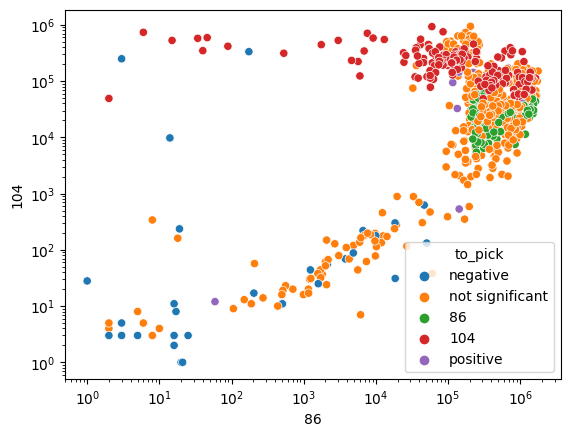

In [120]:
sns.scatterplot(x=hits["value"][86], y=hits["value"][104], data=hits, hue="to_pick")
# set the scale to log
plt.xscale("log")
plt.yscale("log")


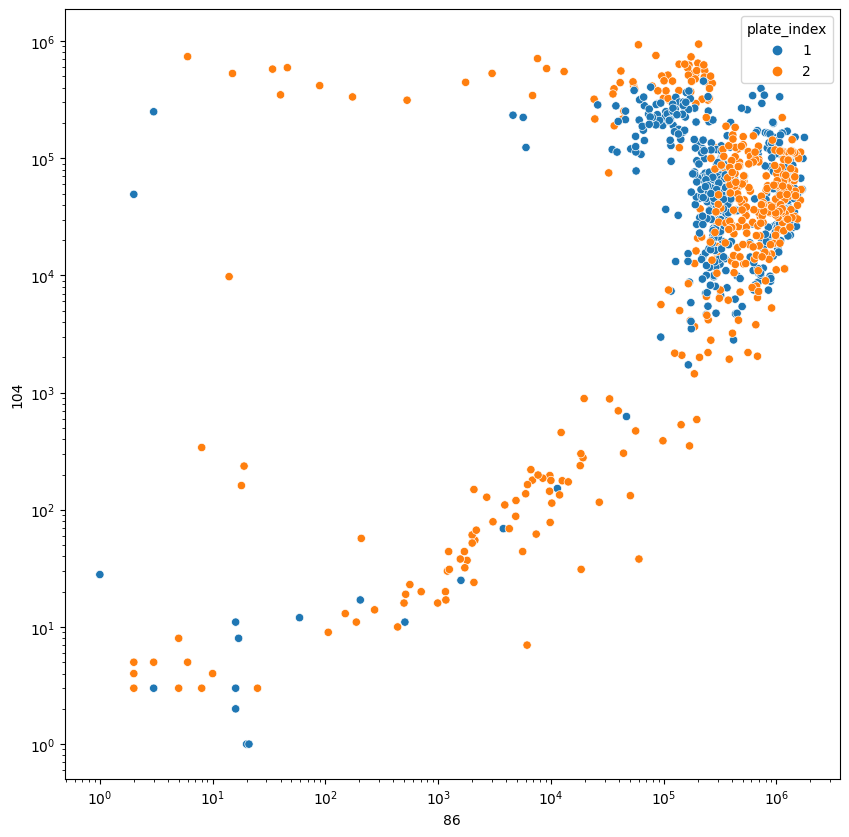

In [121]:
# make a new column with the plate index taken from the last character of the plate_number
hits["plate_index"] = hits["plate_number"].str[-1]

fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x=hits["value"][86], y=hits["value"][104], data=hits, hue="plate_index")
# set the scale to log
plt.xscale("log")
plt.yscale("log")


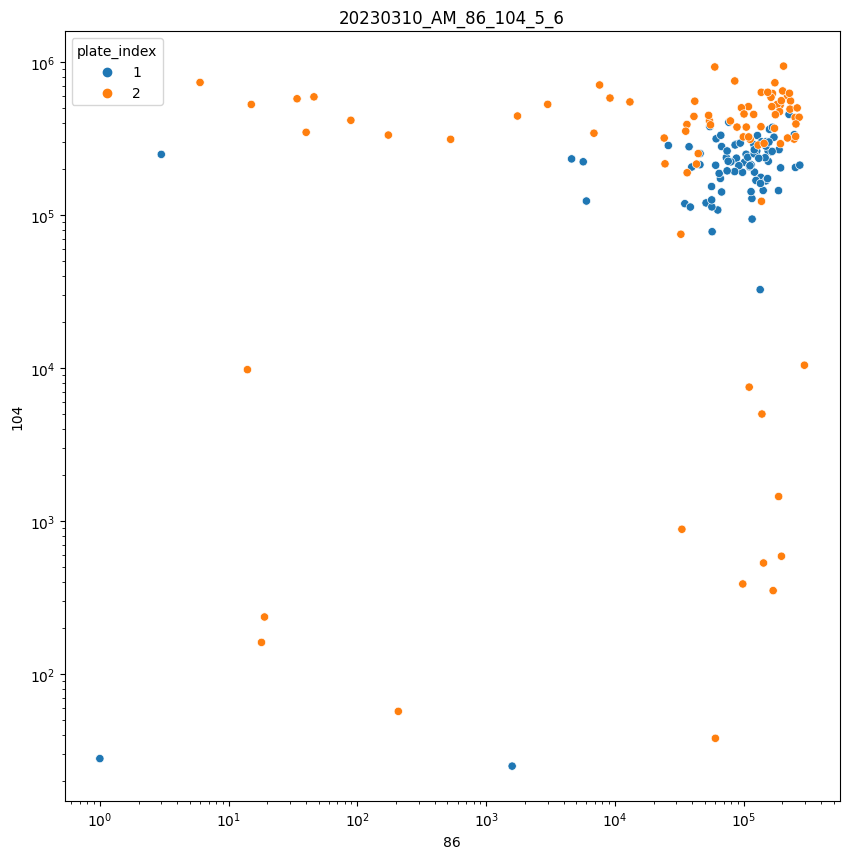

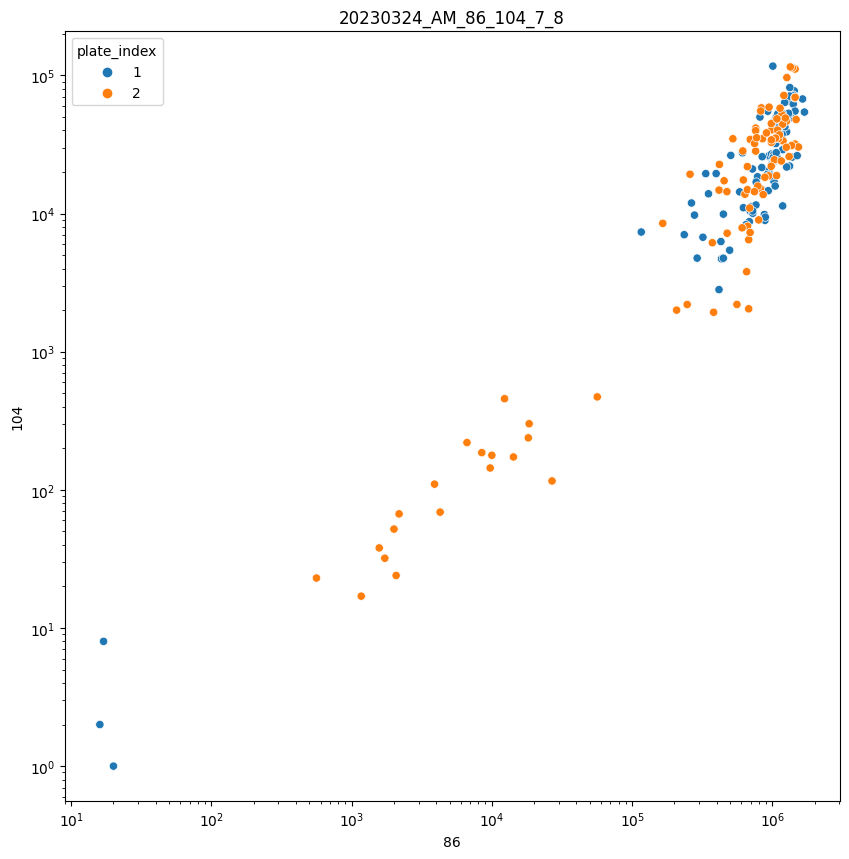

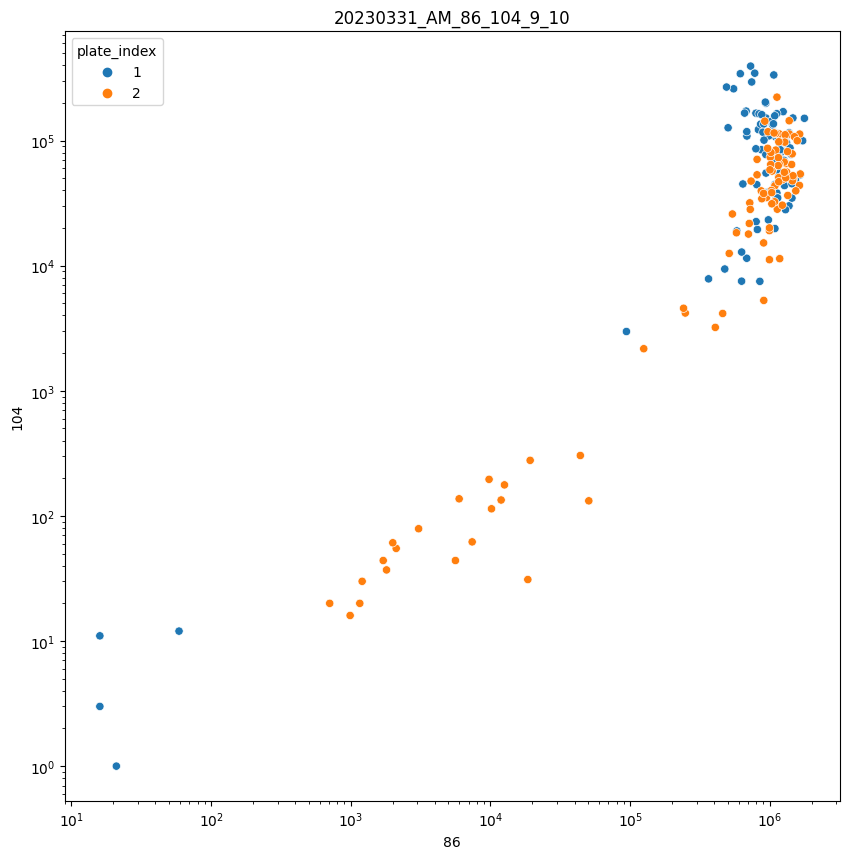

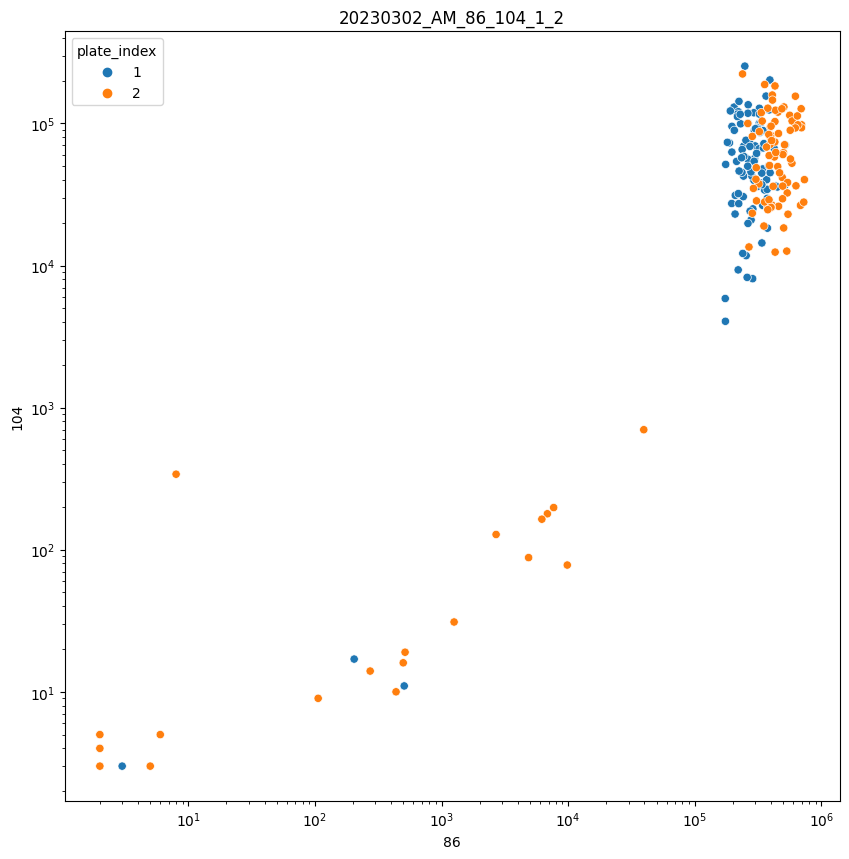

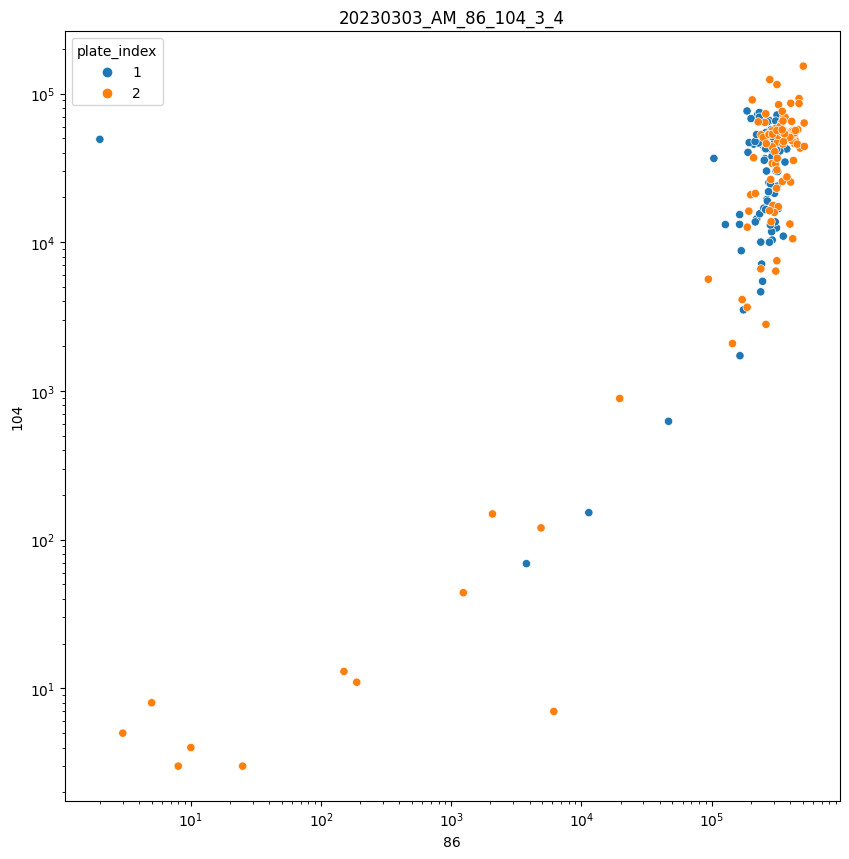

In [122]:
# make a new column called filename that is everything before the last two underscores
hits["filename"] = hits["plate_number"].str.rsplit("_", n=2, expand=True)[0]

# do the above for each individual plate_number
for plate in set(hits["filename"]):
    fig = plt.figure(figsize=(10, 10))
    sns.scatterplot(
        x=hits["value"][86],
        y=hits["value"][104],
        data=hits[hits["filename"] == plate],
        hue="plate_index",
    )
    # set the scale to log
    plt.xscale("log")
    plt.yscale("log")
    plt.title(plate)

In [123]:
# aggregate the hits by the to_pick column and count the number of hits for each plate index
hits.groupby(["to_pick", "plate_index"]).count()

/var/folders/f0/32y2jpfd55l9rzql_c54gnd5r0cbr_/T/ipykernel_53446/4132146273.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  hits.groupby(["to_pick", "plate_index"]).count()


plate_number  row column condition value       \
peptide                                                           86  104   
to_pick         plate_index                                                 
86              1                    130  130    130       130   130  130   
                2                     67   67     67        67    67   67   
104             1                     90   90     90        90    90   90   
                2                     96   96     96        96    96   96   
negative        1                     15   15     15        15    15   15   
                2                     15   15     15        15    15   15   
not significant 1                    230  230    230       230   230  218   
                2                    287  287    287       287   287  275   
positive        1                     15   15     15        15    15   15   
                2                     15   15     15        15    15   15   

                            86/104 104/86 filename  
peptide                                             
to_pick         plate_index                         
86              1              130    130      130  
                2               67     67       67  
104             1               90     90       90  
                2               96     96       96  
negative        1               15     15       15  
                2               15     15       15  
not significant 1              218    218      230  
                2              275    275      287  
positive        1               15     15       15  
                2               15     15       15

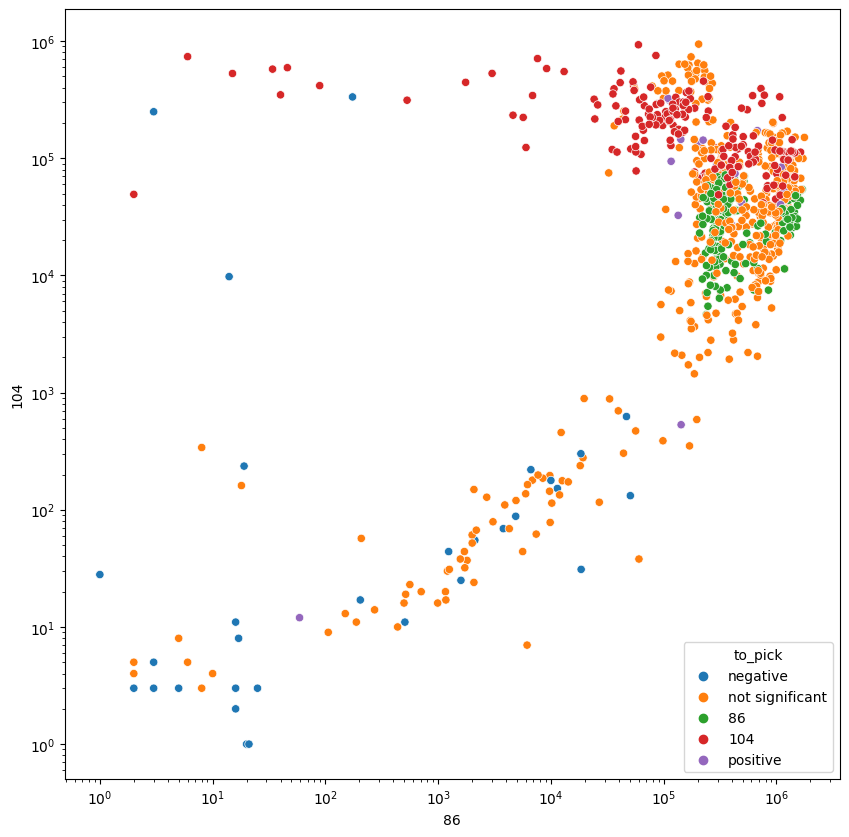

In [124]:
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x=hits["value"][86], y=hits["value"][104], data=hits, hue="to_pick")
# set the scale to log
plt.xscale("log")
plt.yscale("log")

In [125]:
# split the 'plate_number' column on the underscore and take fifth and sixth elements
first_plate = hits["plate_number"].str.split("_", expand=True)[4]
second_plate = hits["plate_number"].str.split("_", expand=True)[5]
absolute_number = []

# iterate over the 'plate_number' column
for i, row in hits.iterrows():
    # get the plate number from the last character of the plate_number
    plate_number = int(row["plate_number"].values[0][-1])
    # if the plate number is in the first plate, add the plate index to the absolute number
    if plate_number == 1:
        absolute_number.append(int(first_plate[i]))
    # if the plate number is in the second plate, add the plate index to the absolute number
    elif plate_number == 2:
        absolute_number.append(int(second_plate[i]))

In [126]:
# add the absolute number to the hits dataframe
hits["plate_number"] = absolute_number

# export df_hits to csv with columns 'to_pick', 'plate_number', 'row', 'column' in that order
for_cherrypicking = hits[hits['to_pick'].isin([86,104])]
#sort on the absolute number
for_cherrypicking = for_cherrypicking.sort_values(by=['plate_number'])
for_cherrypicking[['to_pick', 'plate_number', 'row', 'column']].to_csv('AM_rescreen_S23.csv', index=True)